# Integrate Human Immune Cell datasets with STEP and generate batch-corrected embeddings and gene expressions.

In [1]:
import scanpy as sc
import scanpy.external as sce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
import pandas as pd

from step import scModel
sc.set_figure_params(
    dpi_save=300,
    frameon=False,
    dpi=100,
)

def get_umap(adata, 
                 batch_key, 
                 label_key, 
                 embed_key='X_rep', 
                 save=False,
                 show=True,
                 figdir='figures'):
    if embed_key not in adata.obsm.keys():
        print(f"{embed_key} not found in adata.obsm.keys()")
        return
    sc.pp.neighbors(adata, use_rep=embed_key)
    sc.tl.umap(adata)
    if not save:
        sc.pl.umap(adata, color=[batch_key, label_key])
    else:
        sc.settings.figdir = figdir
        for key in [batch_key, label_key]:
            sc.pl.umap(adata, color=key, save=f"_{embed_key}_{key}_umap.png", show=show)

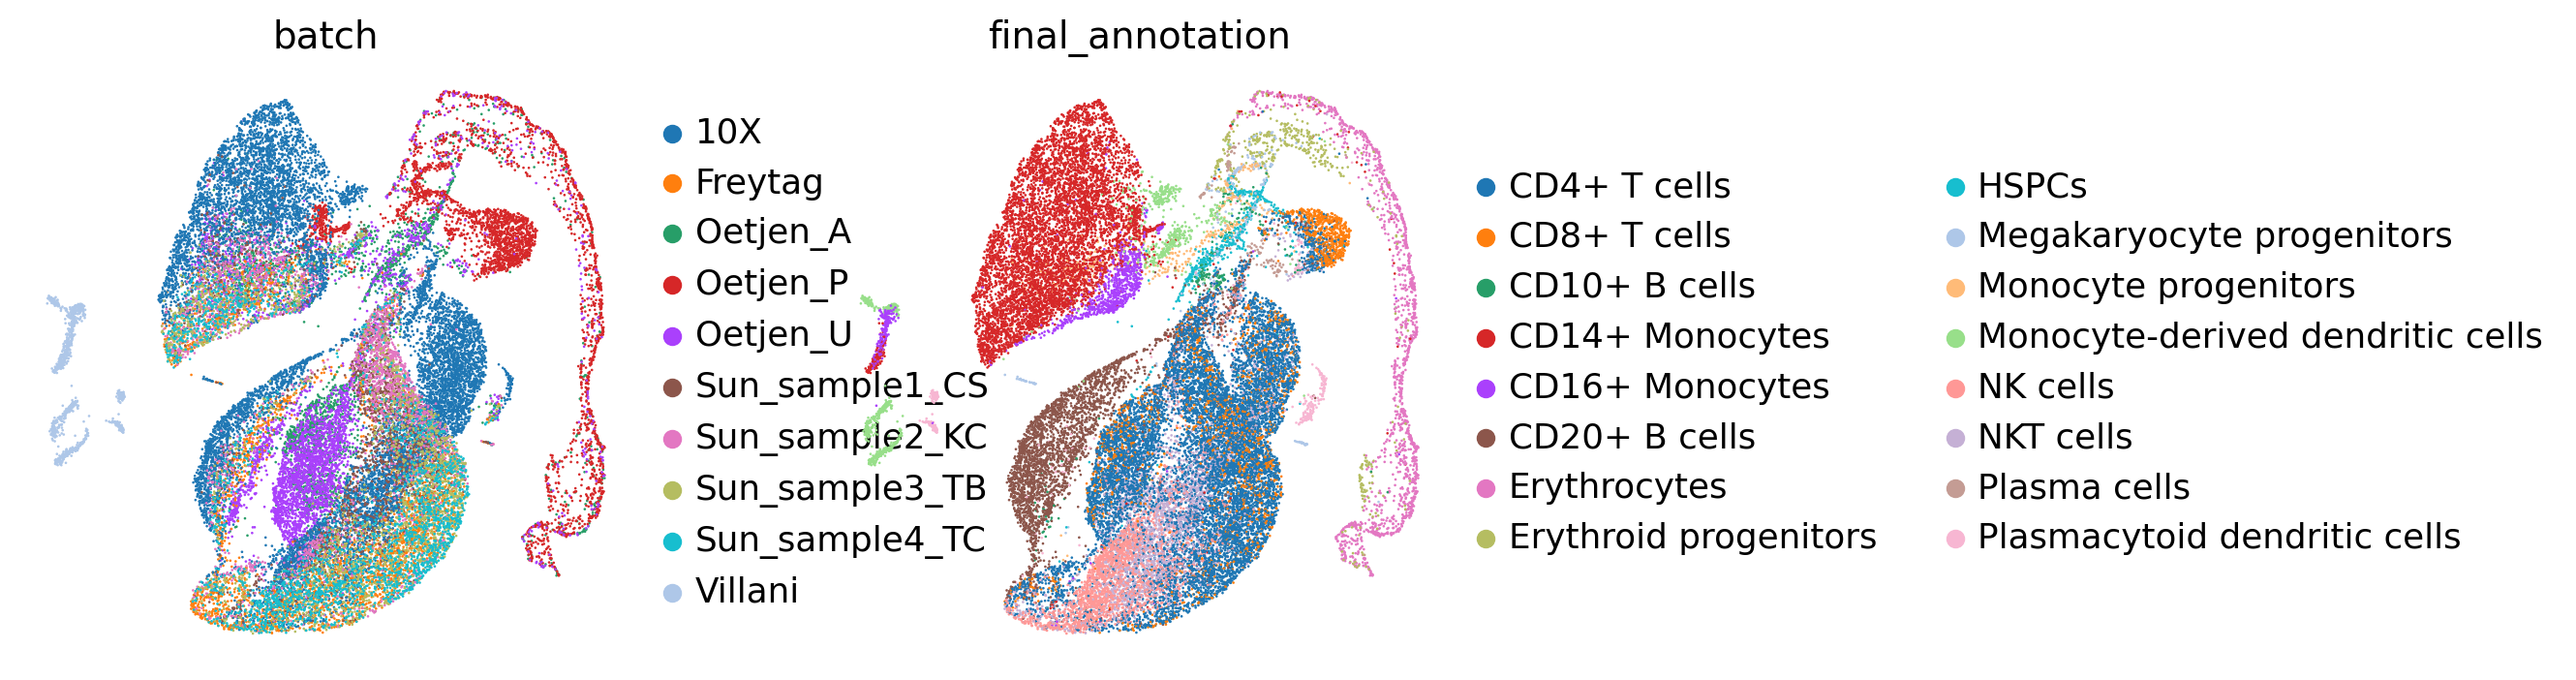

In [2]:
file_path = '/data/scib_benchmark/Immune_ALL_human.h5ad'
batch_key = 'batch'
cell_state_key = 'final_annotation'

adata = sc.read_h5ad(file_path)

sc.pp.pca(adata, layer='counts', n_comps=50)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color=[batch_key, cell_state_key])

In [3]:
stepc = scModel(
    file_path=file_path,
    layer_key='counts',
    batch_key=batch_key,
    class_key=cell_state_key,
    decoder_type='nb',
    module_dim=30,
    hidden_dim=64,
    n_modules=32,
)

Checking layer key
Trying seurat_v3 for hvgs
not log_transformed
================Dataset Info================
Batch key: batch 
Class key: final_annotation 
Number of Batches: 10 
Number of Classes: 16 
Gene Expr: (33506, 2000)
Batch Label: (33506,)


In [4]:
stepc.run(epochs=400, batch_size=1024, split_rate=0.2, tune_epochs=100)

================Dataset Info================
Batch key: batch 
Class key: final_annotation 
Number of Batches: 10 
Number of Classes: 16 
Gene Expr: (33506, 2000)
Batch Label: (33506,)
Performing category random split
Training size for 10X: 8581
Training size for Freytag: 2677
Training size for Oetjen_A: 2068
Training size for Oetjen_P: 2612
Training size for Oetjen_U: 2984
Training size for Sun_sample1_CS: 1380
Training size for Sun_sample2_KC: 1824
Training size for Sun_sample3_TB: 1922
Training size for Sun_sample4_TC: 1936
Training size for Villani: 817
train size: 26801
valid size: 6705
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']
100%|██████████| 400/400 [15:08<00:00,  2.27s/epoch, kl_loss=1.215, recon_loss=732.441, val_kl_loss=1.246/0.386, val_recon_loss=758.566/753.340]  
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_ba

EarlyStopping counter: 20 out of 20
EarlyStopping counter: 4 out of 1


Current Mode: multi_batches_with_ct: ['gene_expr', 'class_label', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']
Current Mode: multi_batches: ['gene_expr', 'batch_label']


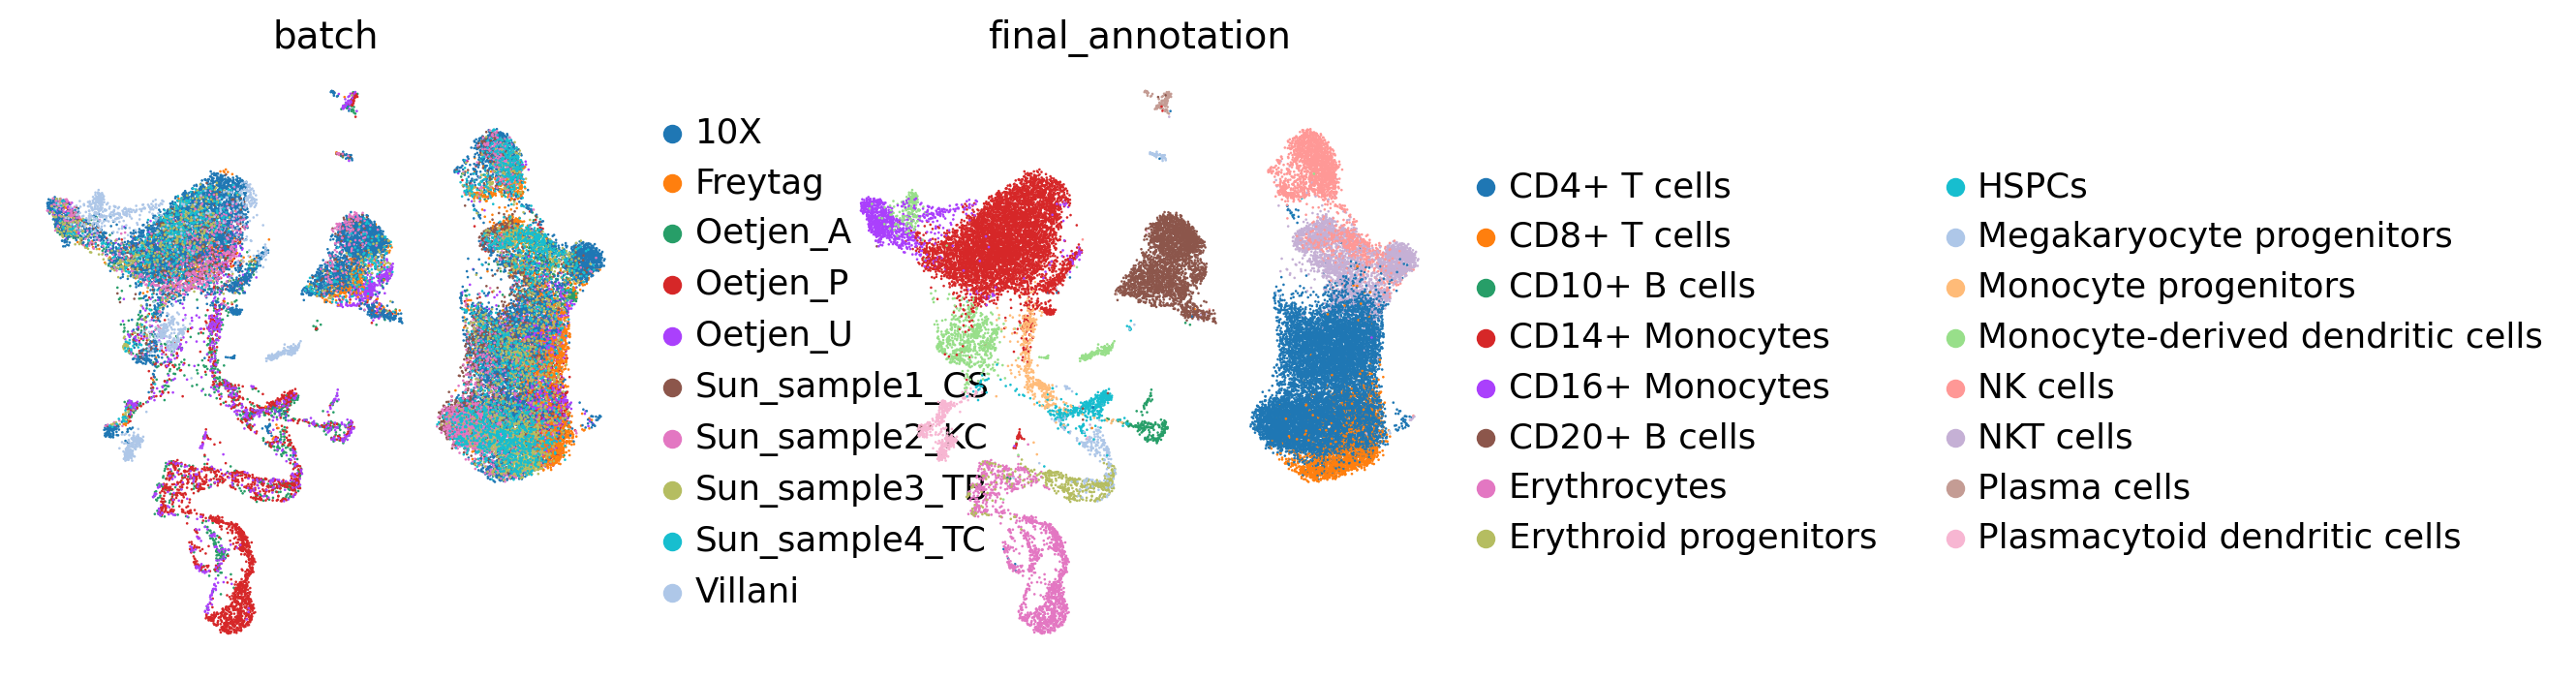

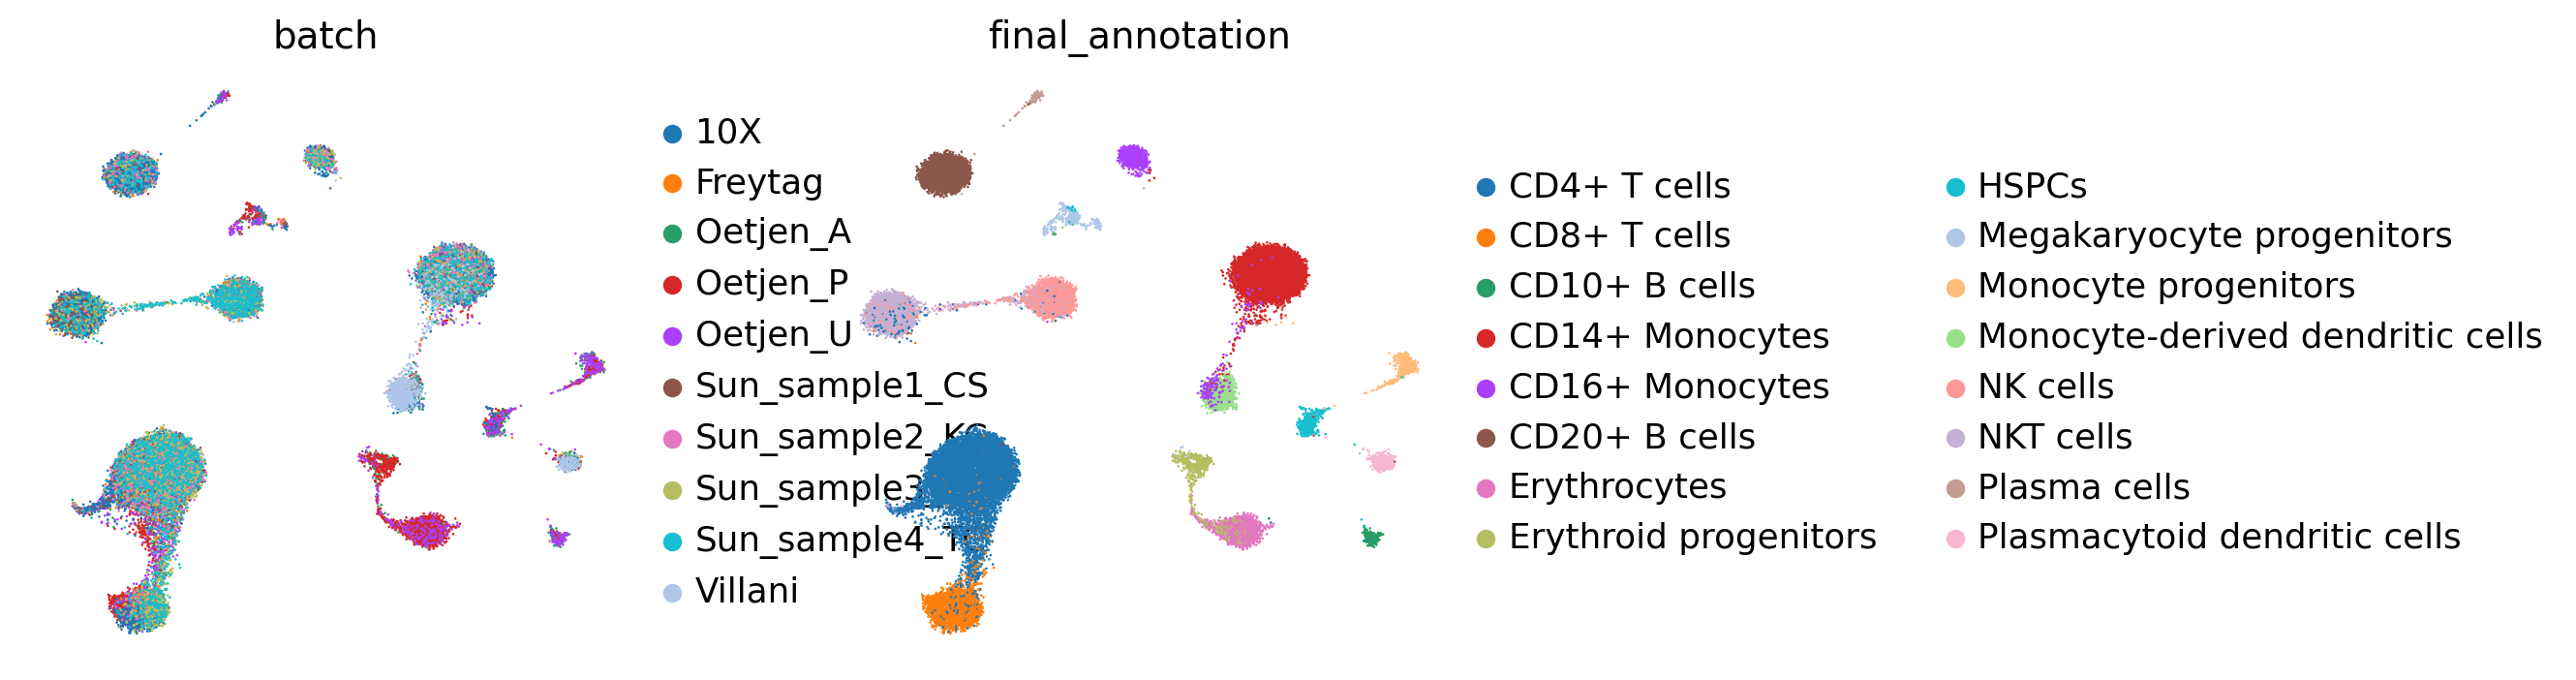

In [5]:
stepc.adata.obsm['X_pca_uncorrected'] = adata.obsm['X_pca']
adata = stepc.adata
get_umap(adata, batch_key, cell_state_key,
             save=False,)
get_umap(adata, batch_key, cell_state_key,
             embed_key='X_anchord',
             save=False,)

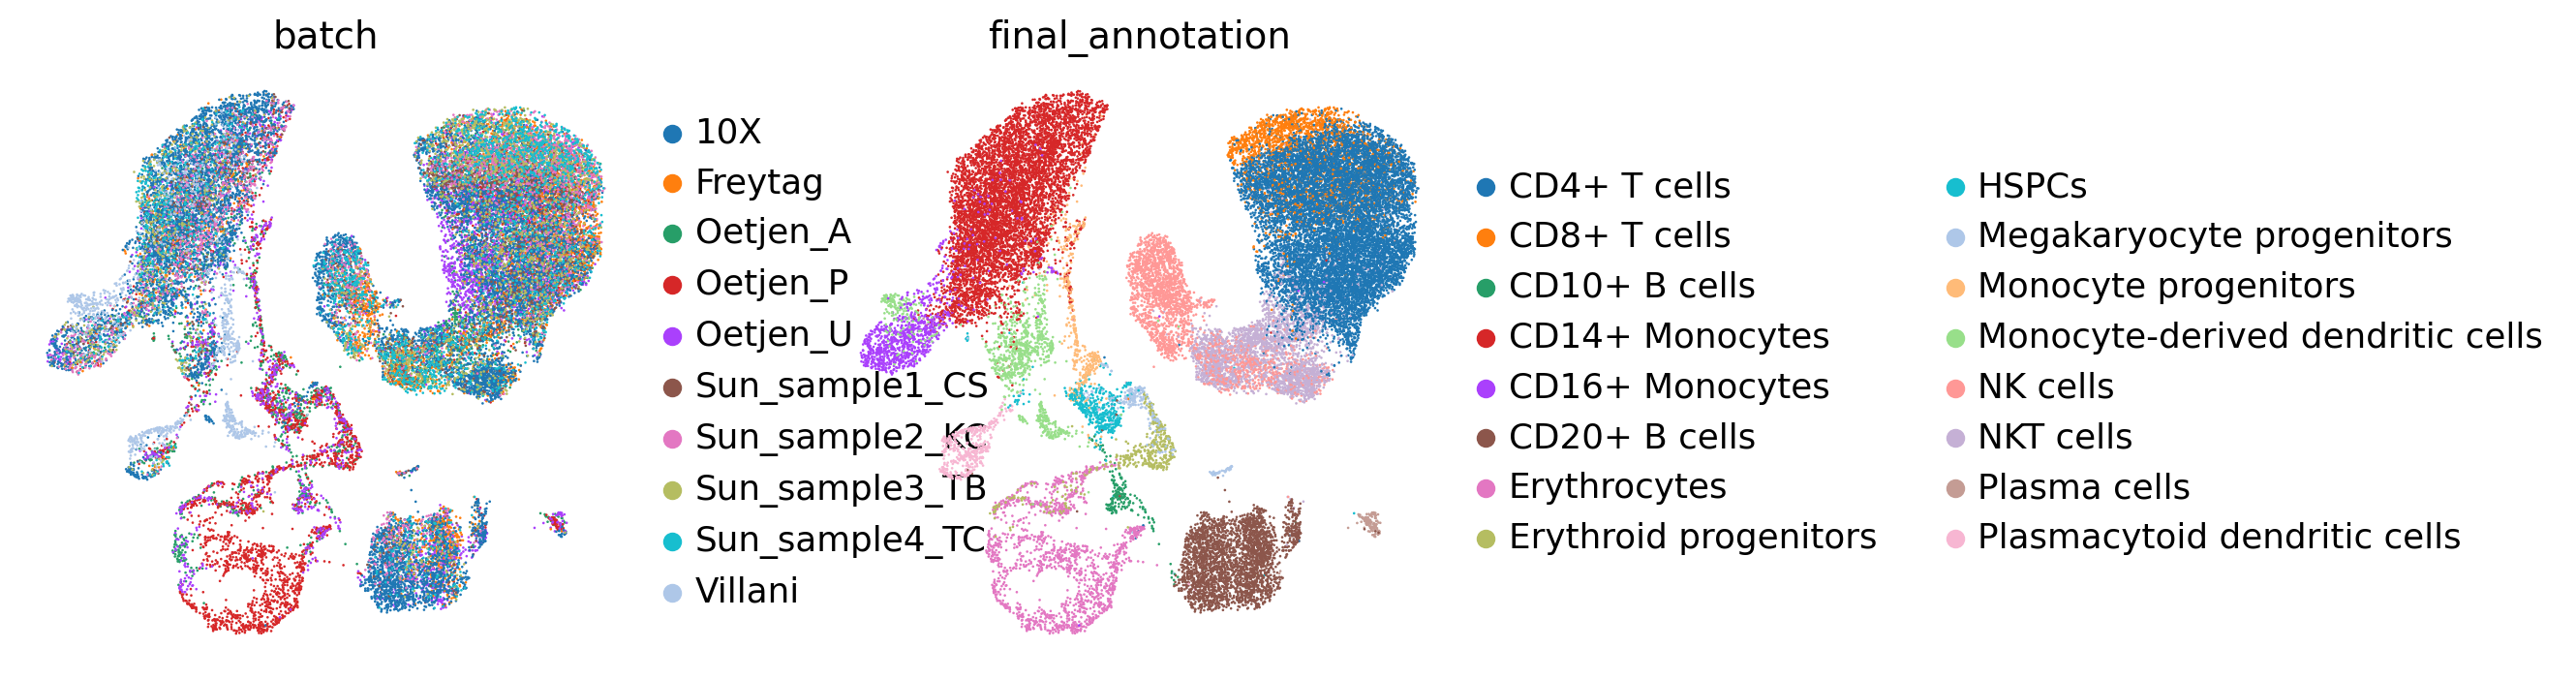

In [6]:
stepc.regress_out(batch_used='all', library_size=1e5)

sc.pp.pca(adata, layer='corrected_counts', n_comps=50)
sc.pp.neighbors(adata, key_added="pca")
sc.tl.umap(adata, neighbors_key="pca",)
sc.pl.umap(adata, color=[batch_key, cell_state_key,])

Computing neighbors:   0%|          | 0/4 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 4/4 [07:19<00:00, 109.85s/it]


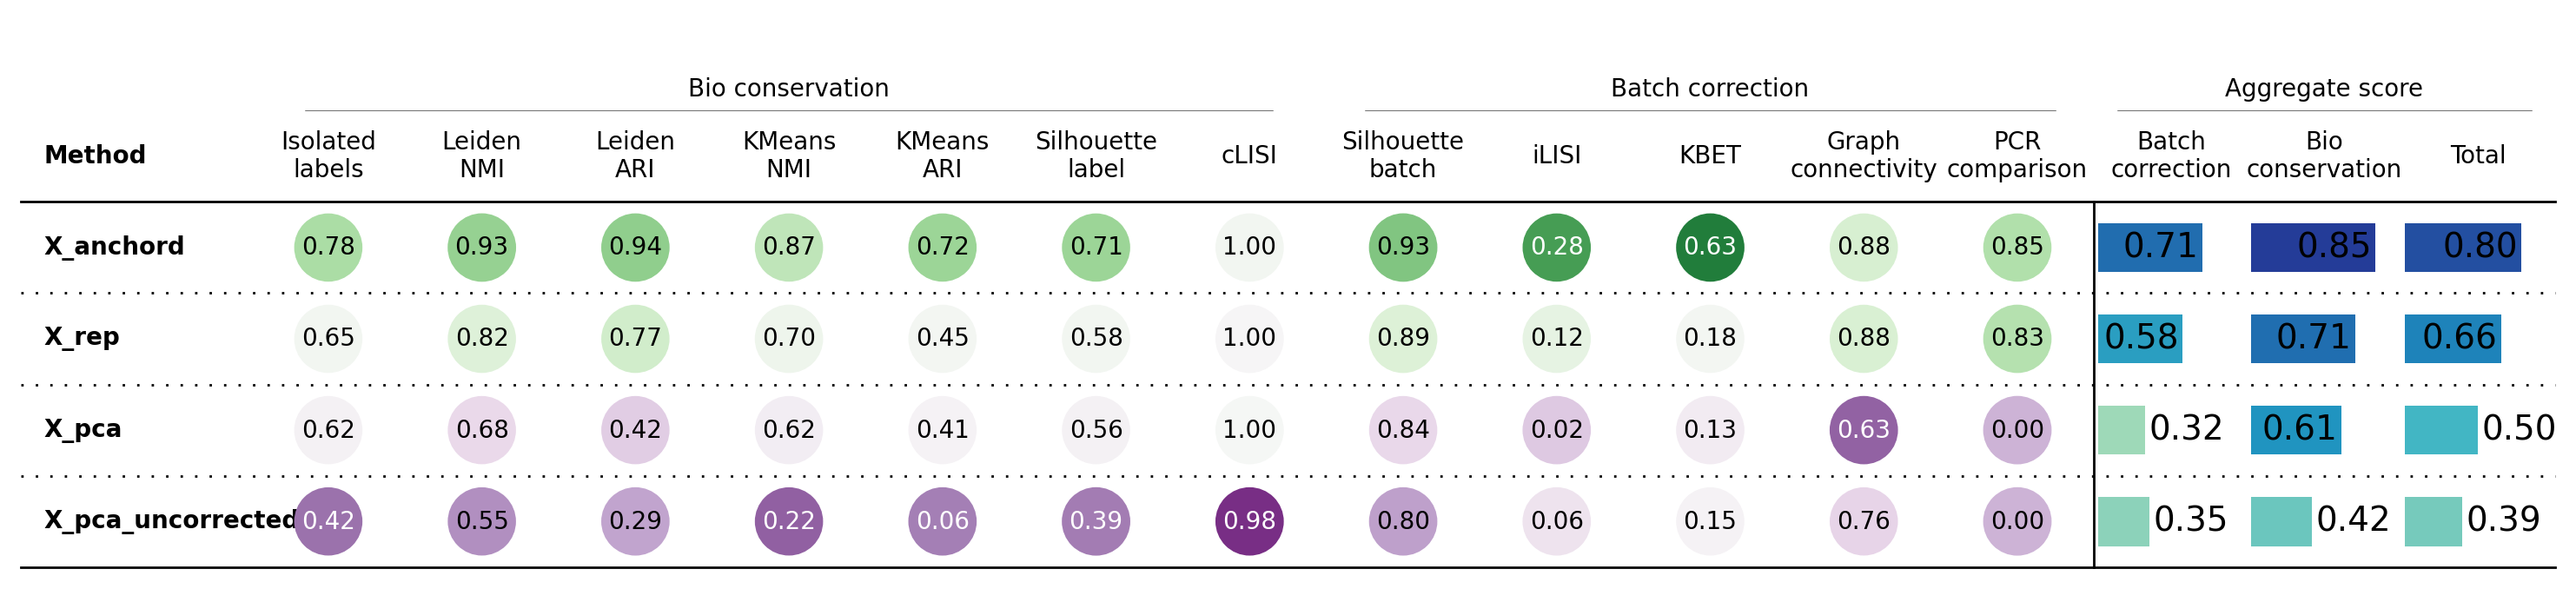

In [7]:
bioc = BioConservation(nmi_ari_cluster_labels_leiden=True)
bm = Benchmarker(
    adata,
    batch_key=batch_key,
    label_key=cell_state_key,
    embedding_obsm_keys=["X_rep", "X_anchord", "X_pca", "X_pca_uncorrected"],
    n_jobs=-1,
    bio_conservation_metrics=bioc,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)